In [1]:
import sys
import numpy as np
import pandas as pd
import pickle as pkl

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector
from tensorflow.keras.optimizers import Adam, Nadam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
np.__version__

'1.19.5'

In [3]:
# convert series to supervised learning
def series_to_supervised(data, column_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in column_names]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
#         print("This should not be happening")
        cols.append(df.shift(-i))
#         print(cols)
        if i == 0:
            names += [('{}(t)'.format(j)) for j in column_names]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in column_names]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


## Reading and Preprocessing Data

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/nzxtdata/Multivariate-Financial-Time-Series-Forecasting-with-Machine-Learning/main/SPXfundamental.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df[df.index.year <= 2020]
predict_date = df[df.index >= "2020-12-01"][['spxclose']]
# df = df[df.index.year <= 2020]

## Converting Data to Supervised

In [7]:
supervised_df = series_to_supervised(df, column_names=df.columns, n_in=120, n_out=20, dropnan=True)

## Creating Train Test Split

In [8]:
values = supervised_df[supervised_df.filter(regex=('t-')).columns]
target_values = supervised_df.drop(columns=supervised_df.filter(regex=('t-')).columns)
target_values = target_values.values
values = values.values

scaler_target = MinMaxScaler(feature_range=(-1 ,1))
scaled_target = scaler_target.fit_transform(target_values)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print("Splitting data into train, validation, test")
train_X, train_y = scaled[:int(len(values)*0.60)], scaled_target[:int(len(values)*0.60)]
valid_X, valid_y = scaled[int(len(values)*0.60):int(len(values)*0.85), :], scaled_target[int(len(values)*0.60):int(len(values)*0.85), :]
test_X, test_y = scaled[int(len(values)*0.85):, :], scaled_target[int(len(values)*0.85):, :]

ncols = len(df.columns)
print("{} input columns identified".format(ncols))

Splitting data into train, validation, test
10 input columns identified


In [9]:
train_X = train_X.reshape((train_X.shape[0], int(train_X.shape[1]/ncols), ncols))
valid_X = valid_X.reshape((valid_X.shape[0], int(valid_X.shape[1]/ncols), ncols))
test_X = test_X.reshape((test_X.shape[0], int(test_X.shape[1]/ncols), ncols))

In [10]:
train_y.shape

(2599, 200)

## Defining Model Architecture

In [11]:
print("Starting network design")

# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(test_y.shape[1]))
adm = Adam(decay=0.2, learning_rate=0.001)
ndm = Nadam(schedule_decay=0.1, learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=adm)

print("Network designed and compiled")
print(model.summary())

Starting network design
Network designed and compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 64)           19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1024)              33792     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dr

## Training the Model

In [12]:
# fit network
print("Starting training")
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(valid_X, valid_y), verbose=1, shuffle=False)
print("Training finished")

Starting training
Epoch 1/100
41/41 [==============================] - 16s 264ms/step - loss: 0.2405 - val_loss: 0.2098
Epoch 2/100
41/41 [==============================] - 9s 230ms/step - loss: 0.1627 - val_loss: 0.2115
Epoch 3/100
41/41 [==============================] - 10s 234ms/step - loss: 0.1434 - val_loss: 0.2051
Epoch 4/100
41/41 [==============================] - 10s 238ms/step - loss: 0.1370 - val_loss: 0.2002
Epoch 5/100
41/41 [==============================] - 10s 233ms/step - loss: 0.1313 - val_loss: 0.1976
Epoch 6/100
41/41 [==============================] - 10s 235ms/step - loss: 0.1261 - val_loss: 0.1954
Epoch 7/100
41/41 [==============================] - 9s 229ms/step - loss: 0.1204 - val_loss: 0.1935
Epoch 8/100
41/41 [==============================] - 9s 228ms/step - loss: 0.1154 - val_loss: 0.1918
Epoch 9/100
41/41 [==============================] - 10s 235ms/step - loss: 0.1101 - val_loss: 0.1904
Epoch 10/100
41/41 [==============================] - 10s 233ms/ste

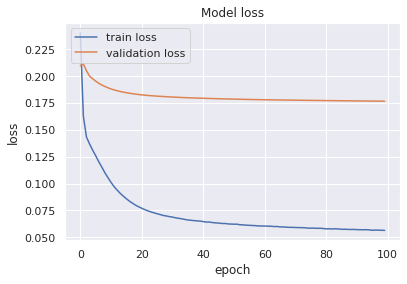

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [20,6]
plt.show()

## Predicting Test Data

In [14]:
predictions = model.predict(test_X)
predictions.shape

(650, 200)

In [15]:
def transform_predictions(pred_df, cols, scaler, n_days_future=30):
    pred_df = pred_df.reshape(-1, len(cols) * n_days_future)

    # np array to df
    denormalized = scaler.inverse_transform(pred_df)
    pred_df = denormalized.reshape((n_days_future, len(cols)))
    pred_df = pd.DataFrame(pred_df, columns=cols)

    return pred_df

## Transforming Predictions

In [24]:
df.columns

Index(['spxopen', 'spxhigh', 'spxlow', 'spxclose', 'spxvolume',
       'US_treasury_yield', 'OPEC/ORB - Value', 'us_gdp_qoq',
       'us_unemployment_ra_%', 'us_longterm_ir_%'],
      dtype='object')

In [27]:
preds = transform_predictions(predictions[0], df.columns, scaler_target, n_days_future=20)['spxclose']
tests = transform_predictions(test_y[1], df.columns, scaler_target, n_days_future=20)['spxclose']

testing = df[['spxopen', 'spxhigh', 'spxlow', 'spxclose', 'spxvolume',
       'US_treasury_yield', 'OPEC/ORB - Value', 'us_gdp_qoq',
       'us_unemployment_ra_%', 'us_longterm_ir_%']][-20:]
testing['pred'] = preds.values
#'spxclose','spxlow', 'spxhigh'

## Plotting Results

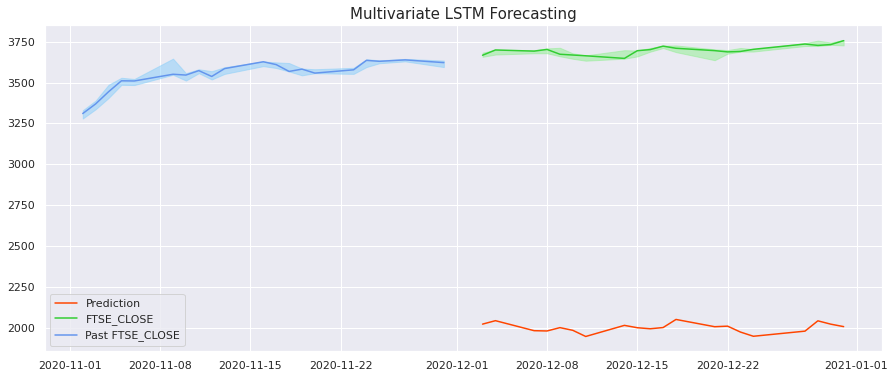

In [28]:
f, ax = plt.subplots(figsize=(15,6))

past = df[(df.index >= "2020-11-01") & (df.index < "2020-12-01")][['spxclose', 'spxhigh', 'spxlow']]
ax.plot(testing[['pred']], color = 'orangered', label='Prediction')
ax.plot(testing[['spxclose']], color = 'limegreen', label='FTSE_CLOSE')
ax.plot(past[['spxclose']], color = 'cornflowerblue', label='Past FTSE_CLOSE')


# ax.fill_between(test.ds, test.pred_lower, test.pred_upper, color='lightcoral', alpha=0.5)
ax.fill_between(testing.index, testing.spxlow, testing.spxhigh, color='lightgreen', alpha=0.5)
ax.fill_between(past.index, past.spxlow, past.spxhigh, color='lightskyblue', alpha=0.5)

ax.set_title("Multivariate LSTM Forecasting", size = 15)
ax.legend()

plt.show()

In [29]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [31]:
timeseries_evaluation_metrics_func(testing.spxclose, testing.pred)

Evaluation metric results:-
MSE is : 2883497.4548395975
MAE is : 1697.7415283203125
RMSE is : 1698.086409709352
MAPE is : 45.90469742516877
R2 is : -4106.465529541137

